## [Forecasting I: univariate, heavy tailed](http://pyro.ai/examples/forecasting_i.html#Forecasting-I:-univariate,-heavy-tailed)

In [1]:
import torch

import pyro
import pyro.distributions as dist
import pyro.poutine as poutine

from pyro.contrib.examples.bart import load_bart_od
from pyro.contrib.forecast import ForecastingModel, Forecaster, backtest, eval_crps

from pyro.infer.reparam import LocScaleReparam, StableReparam
from pyro.ops.tensor_utils import periodic_cumsum, periodic_repeat, periodic_features
from pyro.ops.stats import quantile

import matplotlib.pyplot as plt

%matplotlib inline
assert pyro.__version__.startswith('1.8.3')
pyro.set_rng_seed(20200221)

In [2]:
dataset = load_bart_od()
print(dataset.keys())
print(dataset["counts"].shape)
print(" ".join(dataset["stations"]))

dict_keys(['stations', 'start_date', 'counts'])
torch.Size([78888, 50, 50])
12TH 16TH 19TH 24TH ANTC ASHB BALB BAYF BERY CAST CIVC COLM COLS CONC DALY DBRK DELN DUBL EMBR FRMT FTVL GLEN HAYW LAFY LAKE MCAR MLBR MLPT MONT NBRK NCON OAKL ORIN PCTR PHIL PITT PLZA POWL RICH ROCK SANL SBRN SFIA SHAY SSAN UCTY WARM WCRK WDUB WOAK


#### Pyro’s forecasting framework consists of: - a ForecastingModel base class, whose .model() method can be implemented for custom forecasting models, - a Forecaster class that trains and forecasts using ForecastingModels, and - a backtest() helper to evaluate models on a number of metrics.

##### a simple univariate dataset, say weekly BART train ridership aggregated over all stations in the network. 

In [3]:
T, O, D = dataset['counts'].shape

In [5]:
T // (24 * 7) * 24 * 7

78792

In [6]:
data = dataset['counts'][:T // (24 * 7) * 24 * 7].reshape(T // (24*7), -1).sum(-1).log()

In [7]:
data = data.unsqueeze(-1)

In [8]:
data.shape

torch.Size([469, 1])

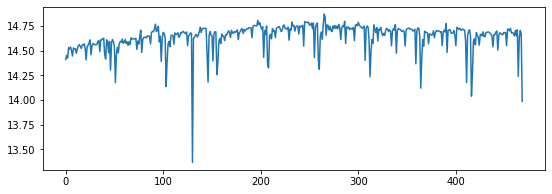

In [9]:
plt.figure(figsize=(9,3))
plt.plot(data)

In [10]:
class Model_1(ForecastingModel):
    # We then implement the .model() method. Since this is a generative model, it shouldn't
    # look at data; however it is convenient to see the shape of data we're supposed to
    # generate, so this inputs a zeros_like(data) tensor instead of the actual data.
    def model(self, zero_data, covariates):
        data_dim = zero_data.size(-1)
        feature_dim = covariates.size(-1)

        bias = pyro.sample('bias', dist.Normal(0, 10).expand([data_dim]).to_event(1))
        weight = pyro.sample('weight',  dist.Normal(0,0.1).expand([feature_dim]).to_event(1))
        predicttion = bias + (weight * covariates).sum(-1, keepdim = True)
        # The prediction should have the same shape as zero_data (duration, obs_dim),
        # but may have additional sample dimensions on the left.
        assert predicttion.shape[-2:] == zero_data.shape

        noise_scale = pyro.sample('noise_scale',  dist.LogNormal(-5, 5).expand([1]).to_event(1))
        noise_dist = dist.Normal(0, noise_scale)

        self.predict(noise_dist, predicttion)

In [11]:
T0 = 0
T2 = data.size(-2)
T1 = T2 - 52

In [20]:
T2

469

In [17]:
time = torch.arange(float(T2)) / 365

In [18]:
covariates = torch.stack([time], dim=-1)

In [23]:
%%time
pyro.set_rng_seed(111)
pyro.clear_param_store()

forecaster = Forecaster(Model_1(), data[:T1], covariates[:T1], learning_rate=0.1)

INFO 	 step    0 loss = 74.955
INFO 	 step  100 loss = 3.36581
INFO 	 step  200 loss = -0.0438504
INFO 	 step  300 loss = -0.572852
INFO 	 step  400 loss = -0.572043
INFO 	 step  500 loss = -0.608833
INFO 	 step  600 loss = -0.608717
INFO 	 step  700 loss = -0.5981
INFO 	 step  800 loss = -0.597871
INFO 	 step  900 loss = -0.611214
INFO 	 step 1000 loss = -0.604468


CPU times: user 5.43 s, sys: 0 ns, total: 5.43 s
Wall time: 5.43 s
